In [21]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Train on CPU...')
else:
  print('CUDA ia available! Train on GPU....')

CUDA is not available. Train on CPU...


In [22]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

#liczba podrzędnych procesów do ładowania danych
num_workers = 0
#Liczba próbek ładowanych na partię.
batch_size = 20
#Procent zestawu treningowego używany jako zestaw walidacyjny.
valid_size =  0.2

#konwersja obrazów do tensorów i normalizacja 
transform = transforms.Compose([
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(10),
                                 transforms.RandomCrop(32, padding=4),
                                 transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                 ])

train_data = datasets.CIFAR10('data',train=True,
                              download=True,transform=transform)
test_data = datasets.CIFAR10('data',train=False,
                             download=True,transform=transform)


num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx,valid_idx = indices[split:],indices[:split]


#próbniki do losowego pobierania podzbiorów danych do trenowania i walidacji.
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                           sampler=train_sampler,num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                           sampler=valid_sampler,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,
                                          num_workers=num_workers)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [23]:
import matplotlib.pyplot as plt

#funkcja pomocniczą która służy do odnormalizowania i wyświetlania obrazu.
def imshow(img):
  img = img / 2 + 0.5
  plt.imshow(np.transpose(img,(1,2,0)))

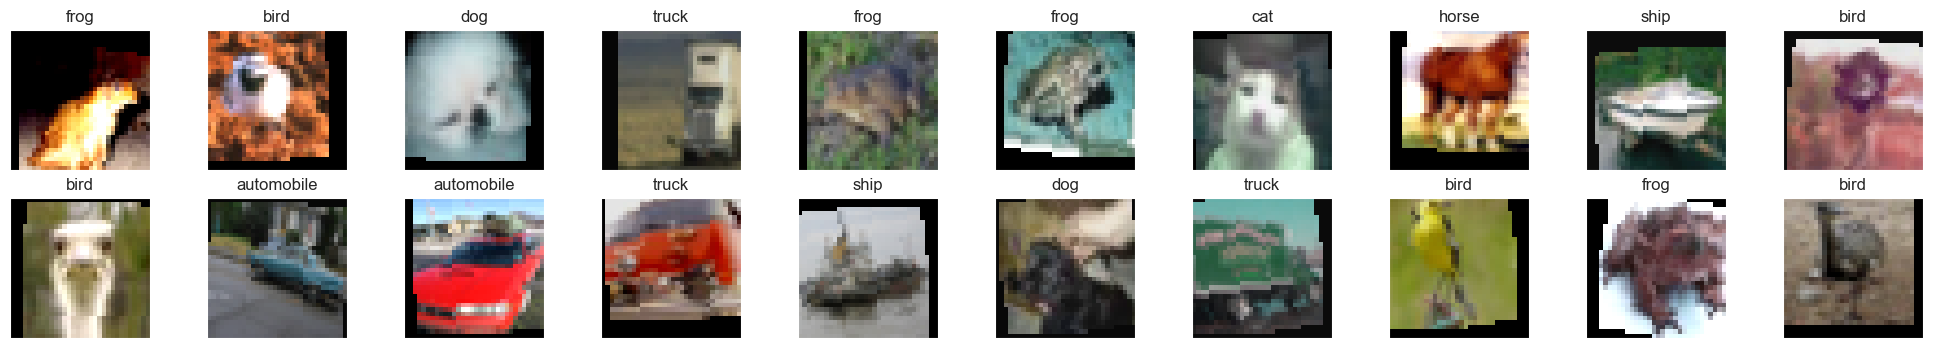

In [24]:
dataiter =  iter(train_loader)
images,labels = next(dataiter)
images = images.numpy()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,int(20/2),idx+1,xticks=[],yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

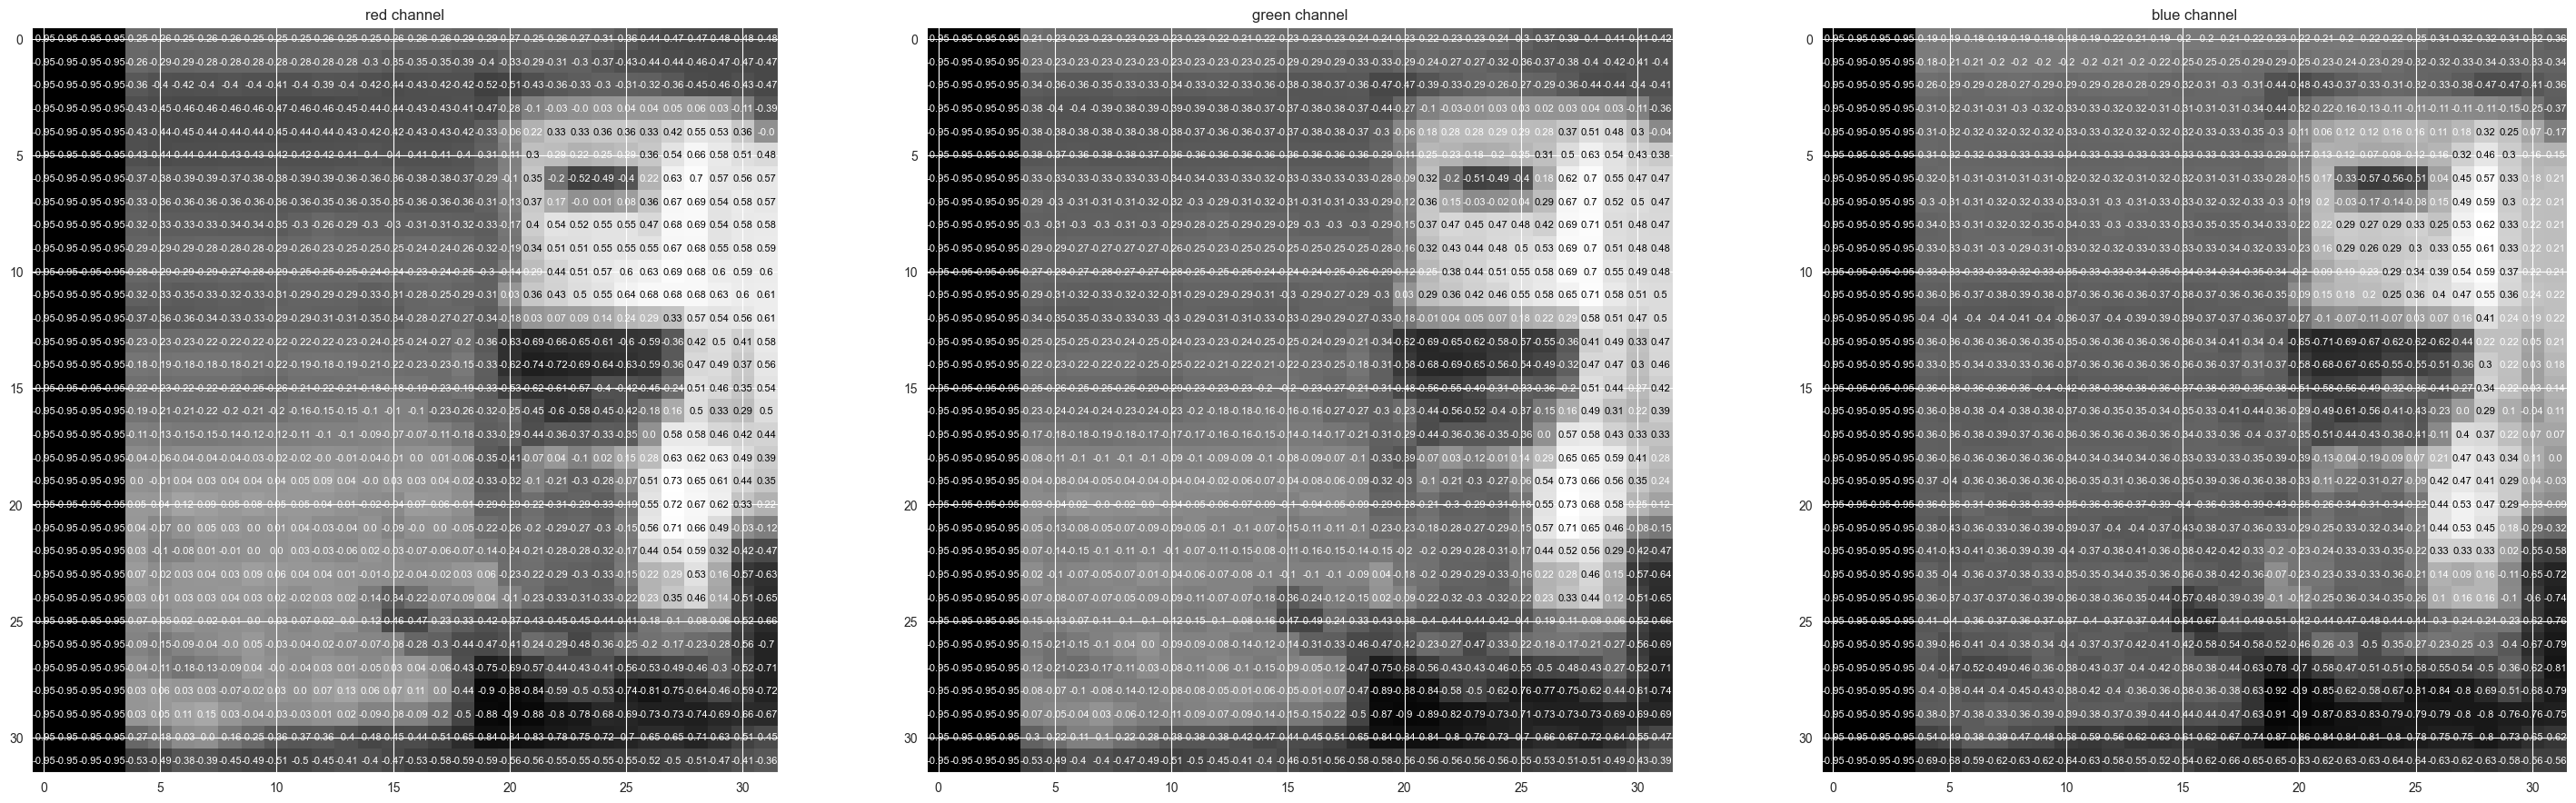

In [25]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x), 
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [26]:
import torch.nn as nn
import torch.nn.functional as F

#architektura CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 1 * 1, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = x.view(-1, 256 * 1 * 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()
print(model)

if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=500, bias=True)
  (fc2): Linea

In [27]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [28]:
n_epochs = 150
valid_loss_min = np.Inf

train_losses = []
valid_losses = []
accuracies = []


for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    correct = 0
    total = 0
    
    #trenowanie modelu
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    accuracy = correct / total
    accuracies.append(accuracy)
    
    #walidacja modelu
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    #Średnie straty treningowe i walidacyjne
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    #Wyświetlenie statystyk treningu i walidacji dla bieżącej epoki 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, accuracy))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.721598 	Validation Loss: 1.398222 	Training Accuracy: 0.362550
Validation loss decreased (inf --> 1.398222).  Saving model ...
Epoch: 2 	Training Loss: 1.407892 	Validation Loss: 1.307086 	Training Accuracy: 0.489450
Validation loss decreased (1.398222 --> 1.307086).  Saving model ...
Epoch: 3 	Training Loss: 1.277237 	Validation Loss: 1.135882 	Training Accuracy: 0.540850
Validation loss decreased (1.307086 --> 1.135882).  Saving model ...
Epoch: 4 	Training Loss: 1.182677 	Validation Loss: 1.080423 	Training Accuracy: 0.576375
Validation loss decreased (1.135882 --> 1.080423).  Saving model ...
Epoch: 5 	Training Loss: 1.110158 	Validation Loss: 0.994073 	Training Accuracy: 0.608100
Validation loss decreased (1.080423 --> 0.994073).  Saving model ...
Epoch: 6 	Training Loss: 1.064345 	Validation Loss: 0.990819 	Training Accuracy: 0.626900
Validation loss decreased (0.994073 --> 0.990819).  Saving model ...
Epoch: 7 	Training Loss: 1.017764 	Validation Loss:

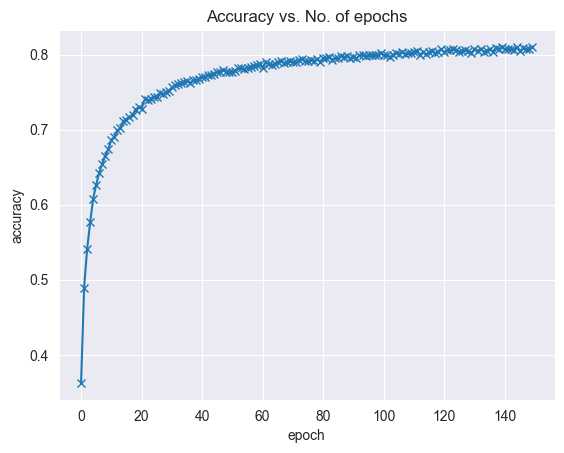

In [29]:
import matplotlib.pyplot as plt

def plot_accuracies(valid_accs):
    plt.plot(valid_accs, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

plot_accuracies(accuracies)

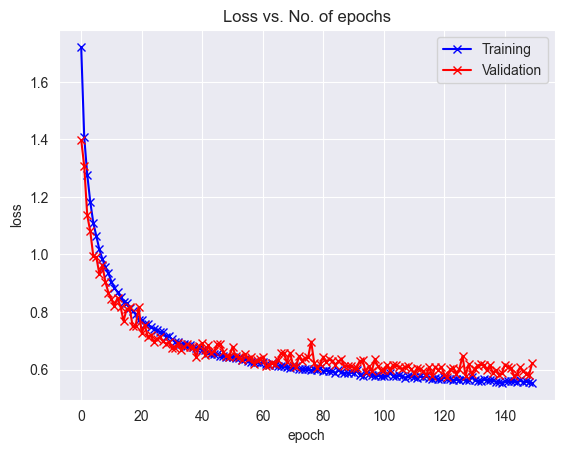

In [30]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, valid_losses):
    plt.plot(train_losses, '-bx')
    plt.plot(valid_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

plot_losses(train_losses, valid_losses)

In [31]:
#Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [32]:
from sklearn.metrics import confusion_matrix

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

confusion_mtx = np.zeros((10, 10), dtype=int)

model.eval() #Przełącza model w tryb ewaluacji
for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    confusion_mtx += confusion_matrix(target.cpu().numpy().astype(int), pred.cpu().numpy().astype(int), labels=list(range(10)))

    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

#Oblicza średnią stratę testową
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.595238

Test Accuracy of airplane: 82% (827/1000)
Test Accuracy of automobile: 89% (892/1000)
Test Accuracy of  bird: 75% (750/1000)
Test Accuracy of   cat: 65% (658/1000)
Test Accuracy of  deer: 80% (809/1000)
Test Accuracy of   dog: 63% (637/1000)
Test Accuracy of  frog: 82% (824/1000)
Test Accuracy of horse: 80% (804/1000)
Test Accuracy of  ship: 88% (883/1000)
Test Accuracy of truck: 88% (886/1000)

Test Accuracy (Overall): 79% (7970/10000)


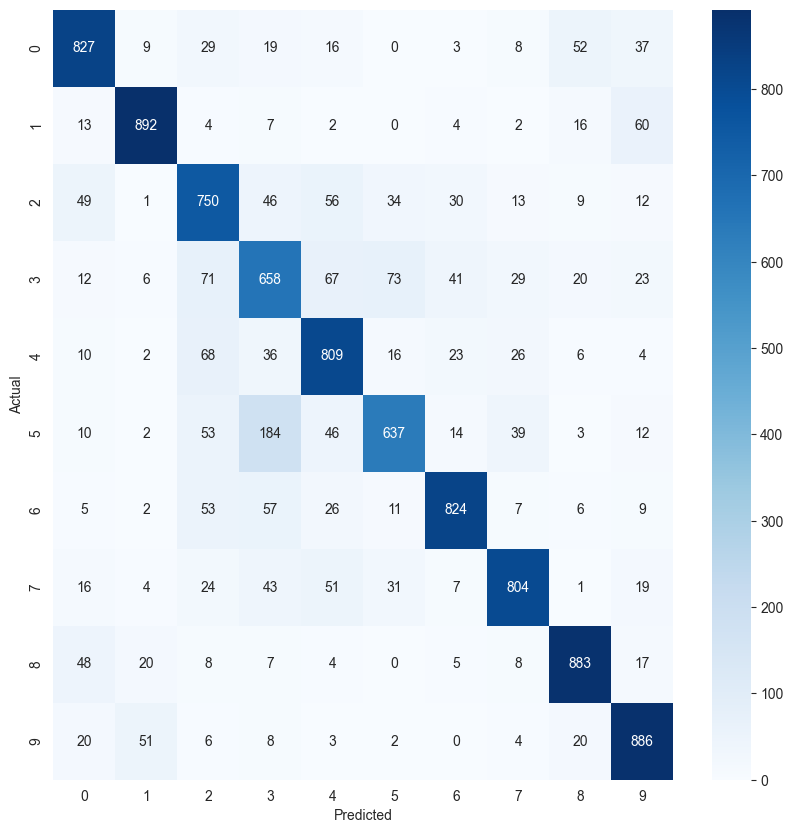

In [33]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [34]:
for i, class_name in enumerate(classes):
    print(f'Number {i} stands for class {class_name}')

Number 0 stands for class airplane
Number 1 stands for class automobile
Number 2 stands for class bird
Number 3 stands for class cat
Number 4 stands for class deer
Number 5 stands for class dog
Number 6 stands for class frog
Number 7 stands for class horse
Number 8 stands for class ship
Number 9 stands for class truck


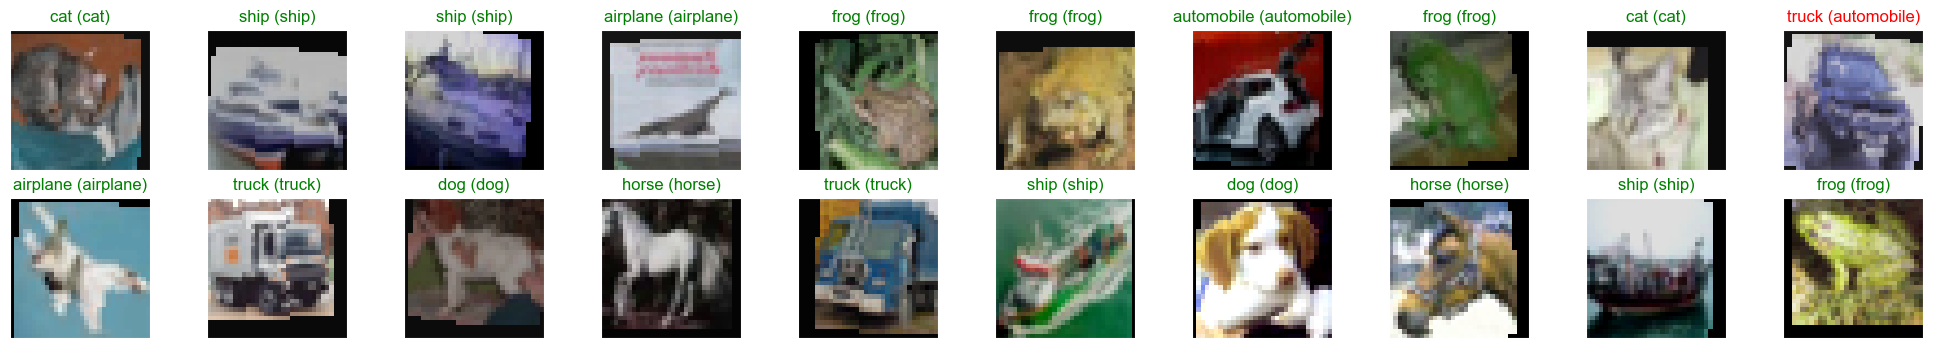

In [35]:
#wizualizacja przykładowych wyników testowych
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

if train_on_gpu:
    images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())


fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))